# Tugas UAS AI: Deep Q-Learning to Control Lunar Lander from Open AI Gym

Cendikia Ishmatuka Srihascaryasmoro (19/439607/TK/48337)

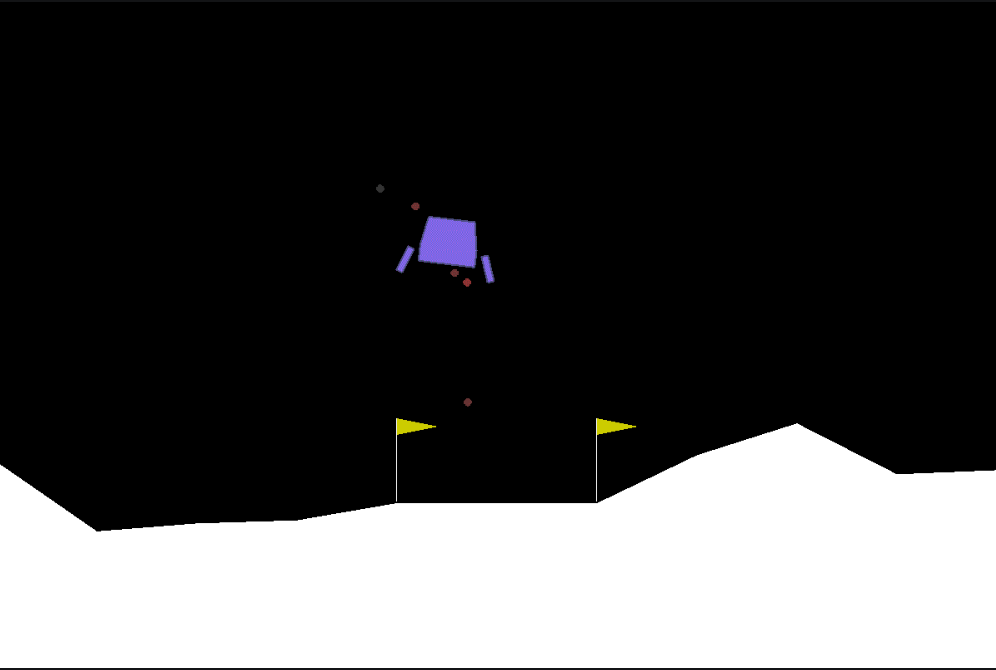

The agent will learn how to control the spaceship untill it is well landed on the ground.

### Import Dependencies

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import gym

### Deep Q-Learning Neural Network

In [2]:
class DeepQLearning(nn.Module):
    def __init__(self, lr = 0.001, input_dims = None, fc1_dims = None,
                 fc2_dims = None, n_actions = None):
        '''
        Class to represent the neural network for Deep Q-Learning.
        Parameters:
        ----------
        lr: float, default: 0.001
            Learning rate for updating weights and biases when doing back propagation.
        input_dims: list, default: None
            Input dimension for the first layer of the neural network (which is the observation space).
        fc1_dims: int, default: None
            Number of first layer's neuron.
        fc2_dims: int, default: None
            Number of second layer's neuron.
        n_actions: int, default: None
            Number of actions given to the environment.
        '''
        super(DeepQLearning, self).__init__()
        self.lr = lr
        self.input_dims = input_dims
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims
        self.n_actions = n_actions
        self.fc1 = nn.Linear(*self.input_dims, self.fc1_dims)
        self.fc2 = nn.Linear(self.fc1_dims, self.fc2_dims)
        self.fc3 = nn.Linear(self.fc2_dims, n_actions)
        self.optimizer = optim.Adam(self.parameters(), lr = self.lr)
        self.loss = nn.MSELoss()
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        print(self.device)
        self.to(self.device)
        
    def forward(self, state):
        '''
        Function to do the forward propagation.
        '''
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        actions = self.fc3(x)
        
        return actions

### Deep Q-Learning Agent

In [3]:
class Agent():
    def __init__(self, gamma = 0.99, epsilon = 1.0, lr = 0.001, input_dims = None, batch_size = 64, 
                 n_actions = None, max_memory_size = 100000, eps_min = 0.01, eps_dec = 5e-4):
        '''
        Class to represent the agent that is going to be trained and learn about environment.
        Parameters:
        ----------
        gamma: float, default: 0.99
            A discount rate, which causes rewards to loses the value over time so more
            immediate rewards are valued more highly.
        epsilon: float, default: 1.0
            the probability rate for the agent chooses a random action to do the Epsilon
            Greedy Exploration Strategy.
        lr: float, default = 0.001
            Learning rate for updating weights and biases when doing back propagation.
        input_dims: list, default = None
            Input dimension for the first layer of the neural network (which is the observation 
            space).
        n_actions: int, default: None
            Number of actions given to the environment.
        max_memory_size: int, default: 100000
            The maximum size of memory to store the parameters.
        eps_min: float, default: 0.01
            Epsilon minimum.
        eps_dec: float, default: 5e-4
            Epsilon decay rate over iterations.
        '''
        self.gamma = gamma
        self.epsilon = epsilon
        self.lr = lr
        self.batch_size = batch_size
        self.action_space = [i for i in range(n_actions)]
        self.memory_size = max_memory_size
        self.batch_size = batch_size
        self.eps_min = eps_min
        self.eps_dec = eps_dec
        
        self.Q_learn = DeepQLearning(self.lr, input_dims = input_dims, n_actions = n_actions,
                                     fc1_dims = 256, fc2_dims = 256)
        self.mem_counter = 0
        
        self.state_memory = np.zeros((self.memory_size,*input_dims), dtype=np.float32)
        self.new_state_memory = np.copy(self.state_memory)
        
        self.action_memory = np.zeros(self.memory_size, dtype=np.int32)
        self.reward_memory = np.zeros(self.memory_size, dtype=np.float32)
        self.condition_memory = np.zeros(self.memory_size, dtype=bool)
        
    def _store(self, state, action, reward, state_new, done):
        '''
        Function to store the state, action, reward, current state, and termination.
        '''
        idx = self.mem_counter%self.memory_size
        self.state_memory[idx] = state
        self.action_memory[idx] = action
        self.reward_memory[idx] = reward
        self.new_state_memory[idx] = state_new
        self.condition_memory[idx] = done
        
        self.mem_counter += 1
        
    def predict(self, obs):
        '''
        Function to predict the action based on given observation.
        '''
        if np.random.random() > self.epsilon:
            state = torch.tensor(obs).to(self.Q_learn.device)
            act = self.Q_learn.forward(state)
            action = torch.argmax(act).item()
        else:   
            action = np.random.choice(self.action_space)
            
        return action
    
    def learn(self):
        '''
        Function to make the agent learn the given environment.
        '''
        if self.mem_counter < self.batch_size:
            return
        
        self.Q_learn.optimizer.zero_grad()
        
        max_memory = min(self.mem_counter, self.memory_size)
        batch = np.random.choice(max_memory, self.batch_size, replace=False)
        batch_idx = np.arange(self.batch_size, dtype=np.int32)
        
        state_batch = torch.tensor(self.state_memory[batch]).to(self.Q_learn.device)
        new_state_batch = torch.tensor(self.new_state_memory[batch]).to(self.Q_learn.device)
        reward_batch = torch.tensor(self.reward_memory[batch]).to(self.Q_learn.device)
        condition_batch = torch.tensor(self.condition_memory[batch]).to(self.Q_learn.device)
        
        action_batch = self.action_memory[batch]
        
        q_eval = self.Q_learn.forward(state_batch)[batch_idx, action_batch]
        q_next = self.Q_learn.forward(new_state_batch)
        q_next[condition_batch] = 0.0
        
        q_target = reward_batch + self.gamma*torch.max(q_next, dim=1)[0]
        
        loss = self.Q_learn.loss(q_target, q_eval).to(self.Q_learn.device)
        loss.backward()
        self.Q_learn.optimizer.step()
        
        self.epsilon = self.epsilon - self.eps_dec if self.epsilon > self.eps_min else self.eps_min

### Define the Environment and the Agent

In [4]:
env = gym.make('LunarLander-v2')
agent = Agent(gamma = 0.99, 
              epsilon = 1.0, 
              batch_size = 64, 
              n_actions = 4, 
              eps_min = 0.01,
              input_dims = [8],
              lr = 0.001)
n_episode = 2000

cuda:0


### Let's Train The Agent

In [5]:
for i in range(n_episode):
    scores = []
    score = 0
    done = False
    obs = env.reset()
    while not done:
        action = agent.predict(obs)
        obs_new, reward, done, info = env.step(action)
        score += reward
        agent._store(obs, action, reward, obs_new, done)
        agent.learn()
        obs = obs_new
        scores.append(score)

    avg_score = np.mean(scores)
    if (i)%100==0:
        print(f"Episode: {i}, score: {score:.2f}, average score: {avg_score:.2f}, epsilon: {agent.epsilon:.2f}")

Episode: 0, score: -361.72, average score: -72.65, epsilon: 0.98
Episode: 100, score: -15.89, average score: 43.83, epsilon: 0.01
Episode: 200, score: 23.78, average score: 12.97, epsilon: 0.01
Episode: 300, score: -73.45, average score: 77.87, epsilon: 0.01
Episode: 400, score: -200.74, average score: 35.90, epsilon: 0.01
Episode: 500, score: 216.26, average score: 55.18, epsilon: 0.01
Episode: 600, score: 295.58, average score: 111.26, epsilon: 0.01
Episode: 700, score: 256.65, average score: 67.66, epsilon: 0.01
Episode: 800, score: 279.35, average score: 78.47, epsilon: 0.01
Episode: 900, score: 190.79, average score: 48.96, epsilon: 0.01
Episode: 1000, score: 177.56, average score: 164.44, epsilon: 0.01
Episode: 1100, score: -84.76, average score: 31.85, epsilon: 0.01
Episode: 1200, score: 279.29, average score: 90.95, epsilon: 0.01
Episode: 1300, score: 314.85, average score: 97.02, epsilon: 0.01
Episode: 1400, score: 234.75, average score: 78.83, epsilon: 0.01
Episode: 1500, sco

### Testing the agent

In [8]:
for i in range(5):
    obs = env.reset()
    done = False
    score = 0
    
    while not done:
        env.render()
        action = agent.predict(obs)
        obs, reward, done, info = env.step(action)
        score += reward
        
    print(f"Episode: {i+1}, score: {score}")
    
env.close()

Episode: 1, score: 171.6937135939367
Episode: 2, score: 219.0922804865895
Episode: 3, score: 176.44956103928695
Episode: 4, score: 147.14593168796102
Episode: 5, score: 263.2470210680102
